### Import needed packages

In [40]:
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm
import numpy as np
from datetime import datetime
from meteostat import Point, Daily
from scipy.stats import chi2_contingency


### Data Preparation

In [41]:
# Path to CSV's
path = '../data/raw'
# Get list of all CSV's in folder
all_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
# Read each CSV and store it in a list of dataframes
df_list = [pd.read_csv(file) for file in all_files]
# Concatenate
combined_df = pd.concat(df_list, ignore_index=True)
# Save combined dataframe as new CSV
combined_df.to_csv('all_bike_data.csv', index=False)

### Specify Time Period and Location for Weather Data

In [42]:
# Set time period for analysis
start = datetime(2024, 8, 1)
end = datetime(2025, 8, 31)

# Create location point for NYC
nyc_location = Point(40.7128, -74.0060, 10)

# Get historical data
data = Daily(nyc_location, start, end)
weather_df = data.fetch()

# Data check
print(weather_df.head())

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2024-08-01  28.7  25.0  33.9   0.0   0.0  <NA>   6.1  <NA>  1013.9  <NA>
2024-08-02  28.1  24.5  32.3   2.4   0.0  <NA>   8.1  <NA>  1011.8  <NA>
2024-08-03  26.7  23.3  32.8   7.1   0.0  <NA>  10.3  <NA>  1010.6  <NA>
2024-08-04  24.2  22.8  27.8   8.7   0.0  <NA>   9.8  <NA>  1013.3  <NA>
2024-08-05  27.3  23.3  33.3   0.0   0.0  <NA>   9.0  <NA>  1015.9  <NA>


### Check merged ride data

In [43]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137673 entries, 0 to 1137672
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             1137673 non-null  object 
 1   rideable_type       1137673 non-null  object 
 2   started_at          1137673 non-null  object 
 3   ended_at            1137673 non-null  object 
 4   start_station_name  1137669 non-null  object 
 5   start_station_id    1137669 non-null  object 
 6   end_station_name    1134663 non-null  object 
 7   end_station_id      1134112 non-null  object 
 8   start_lat           1137672 non-null  float64
 9   start_lng           1137672 non-null  float64
 10  end_lat             1136290 non-null  float64
 11  end_lng             1136290 non-null  float64
 12  member_casual       1137673 non-null  object 
dtypes: float64(4), object(9)
memory usage: 112.8+ MB


### Check for missing data

In [44]:
combined_df.isnull().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name       4
start_station_id         4
end_station_name      3010
end_station_id        3561
start_lat                1
start_lng                1
end_lat               1383
end_lng               1383
member_casual            0
dtype: int64

### Convert to datetime

In [45]:
combined_df['started_at'] = pd.to_datetime(combined_df['started_at'])
combined_df['ended_at'] = pd.to_datetime(combined_df['ended_at'])

### Creating a ride_duration column

In [46]:
# Subtracting the two colums creates a Timedelta object
combined_df['ride_duration'] = combined_df['ended_at'] - combined_df['started_at']

# Convert to minutes
combined_df['ride_duration_minutes'] = combined_df['ride_duration'].dt.total_seconds() / 60

### Examine Nulls

In [47]:
null_counts = combined_df.isnull().sum()
null_percentages = (combined_df.isnull().sum() / len(combined_df)) * 100
missing_data_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentages
})
print(missing_data_summary[missing_data_summary['Null Count'] > 0].sort_values(by='Null Percentage', ascending=False))

                    Null Count  Null Percentage
end_station_id            3561         0.313007
end_station_name          3010         0.264575
end_lat                   1383         0.121564
end_lng                   1383         0.121564
start_station_name           4         0.000352
start_station_id             4         0.000352
start_lng                    1         0.000088
start_lat                    1         0.000088


In [48]:
# Identify all columns that contain at least one null value
cols_with_nulls = combined_df.columns[combined_df.isnull().any()].tolist()

if not cols_with_nulls:
    print("No columns with null values were found!")
else:
    print(f"🔍 Analyzing nulls for columns: {', '.join(cols_with_nulls)}\n")

# Loop through each column that has nulls and perform the test
for col in cols_with_nulls:
    print(f"--- Analysis for '{col}' ---")

    # Create a contingency table (cross-tabulation)
    # This table counts the occurrences of null/not-null for each rider type.
    contingency_table = pd.crosstab(combined_df['member_casual'], combined_df[col].isnull())
    contingency_table.columns = ['Not Null', 'Is Null'] # Rename for clarity

    print("Distribution of Null vs. Not Null values:")
    print(contingency_table)
    print("\n")

    # Perform the Chi-Squared test on the contingency table
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print(f"📊 Chi-Squared Test p-value: {p_value:.4g}") # .4g formats nicely

    # Interpret the result based on the p-value
    alpha = 0.05 # Standard significance level
    if p_value < alpha:
        print(f"Conclusion: The p-value is less than {alpha}, so we REJECT the null hypothesis.")
        print("This suggests there IS a statistically significant association between rider type and missing values in this column.\n")
    else:
        print(f"Conclusion: The p-value is greater than {alpha}, so we FAIL to reject the null hypothesis.")
        print("This suggests there is NO evidence of an association. The nulls appear to be random with respect to rider type.\n")

🔍 Analyzing nulls for columns: start_station_name, start_station_id, end_station_name, end_station_id, start_lat, start_lng, end_lat, end_lng

--- Analysis for 'start_station_name' ---
Distribution of Null vs. Not Null values:
               Not Null  Is Null
member_casual                   
casual           264027        4
member           873642        0


📊 Chi-Squared Test p-value: 0.00232
Conclusion: The p-value is less than 0.05, so we REJECT the null hypothesis.
This suggests there IS a statistically significant association between rider type and missing values in this column.

--- Analysis for 'start_station_id' ---
Distribution of Null vs. Not Null values:
               Not Null  Is Null
member_casual                   
casual           264027        4
member           873642        0


📊 Chi-Squared Test p-value: 0.00232
Conclusion: The p-value is less than 0.05, so we REJECT the null hypothesis.
This suggests there IS a statistically significant association between rider ty

Statistical testing revealed that the presence of missing data is not random but has a significant association with the user type.

Missing data related to ride completion (such as end_station_name and end_lat) is disproportionately linked to casual riders when compared to annual members.

This pattern suggests that data gaps are likely a signal of user behavior—potentially indicating that casual riders are more prone to improperly docking bikes rather than being simple, random system errors.

### Remove nulls

To focus the analysis on valid, complete trips, all records with missing data are excluded. The initial data exploration showed these nulls were not random errors but a distinct pattern linked to casual riders possibly failing to complete their rides in the system correctly. Removing them ensures the analysis of rider behavior is more accurate and reliable.

In [49]:
combined_df.dropna(inplace=True)

### Extract hour of day and day of week columns

In [50]:
combined_df['start_hour'] = combined_df['started_at'].dt.hour
combined_df['day_of_week'] = combined_df['started_at'].dt.dayofweek

### Ensure started_at is a datetime object & Resample by day D and get number of rides per day

In [51]:
combined_df.set_index('started_at' , inplace=True)

daily_rides = combined_df['ride_id'].resample('D').count()

print(daily_rides.head())

started_at
2024-07-31       6
2024-08-01    3897
2024-08-02    3335
2024-08-03    3024
2024-08-04    2573
Freq: D, Name: ride_id, dtype: int64


### Merge ride data with weather data

In [52]:
# Convert daily_rides to dataframe
daily_rides_df = daily_rides.reset_index()

# Rename for clarity
daily_rides_df.columns = ['date', 'ride_count']

In [53]:
print(weather_df.head())


            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2024-08-01  28.7  25.0  33.9   0.0   0.0  <NA>   6.1  <NA>  1013.9  <NA>
2024-08-02  28.1  24.5  32.3   2.4   0.0  <NA>   8.1  <NA>  1011.8  <NA>
2024-08-03  26.7  23.3  32.8   7.1   0.0  <NA>  10.3  <NA>  1010.6  <NA>
2024-08-04  24.2  22.8  27.8   8.7   0.0  <NA>   9.8  <NA>  1013.3  <NA>
2024-08-05  27.3  23.3  33.3   0.0   0.0  <NA>   9.0  <NA>  1015.9  <NA>


In [54]:
# Turn 'time' index into regular column
weather_df.reset_index(inplace=True)

In [55]:
# Rename time column to date so both dataframes have matching column
weather_df.rename(columns={'time': 'date'}, inplace=True)

In [56]:
# Merge the dataframes on the date column
merged_df = pd.merge(daily_rides_df, weather_df, on='date', how='inner')

In [57]:
# Display first few rows to  confirm
print(merged_df.head())

        date  ride_count  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  \
0 2024-08-01        3897  28.7  25.0  33.9   0.0   0.0  <NA>   6.1  <NA>   
1 2024-08-02        3335  28.1  24.5  32.3   2.4   0.0  <NA>   8.1  <NA>   
2 2024-08-03        3024  26.7  23.3  32.8   7.1   0.0  <NA>  10.3  <NA>   
3 2024-08-04        2573  24.2  22.8  27.8   8.7   0.0  <NA>   9.8  <NA>   
4 2024-08-05        3620  27.3  23.3  33.3   0.0   0.0  <NA>   9.0  <NA>   

     pres  tsun  
0  1013.9  <NA>  
1  1011.8  <NA>  
2  1010.6  <NA>  
3  1013.3  <NA>  
4  1015.9  <NA>  


# Visualizations

### Busiest Hour of the Day

<Axes: title={'center': 'Bike Rentals by Hour of Day'}, xlabel='Hour of day', ylabel='Total Number of Rides'>

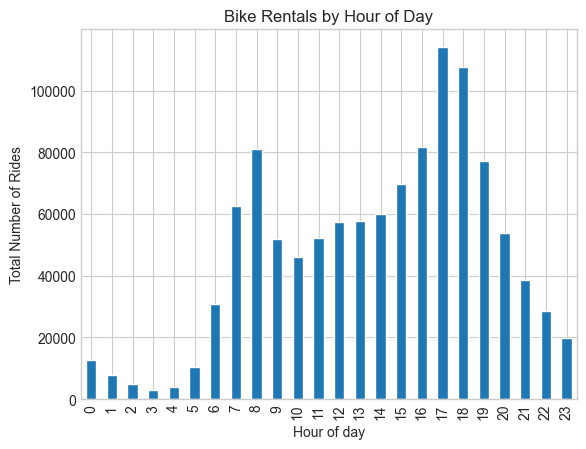

In [58]:
# Busiest hour of day
hourly_counts = combined_df.groupby('start_hour')['ride_id'].count()

# Plot Results
hourly_counts.plot(kind='bar',
                   title='Bike Rentals by Hour of Day',
                   xlabel='Hour of day',
                   ylabel='Total Number of Rides')


### Busiest Days of the Week

<Axes: title={'center': 'Bike Rentals by Day of Week'}, xlabel='Day of Week', ylabel='Total Number of Rides'>

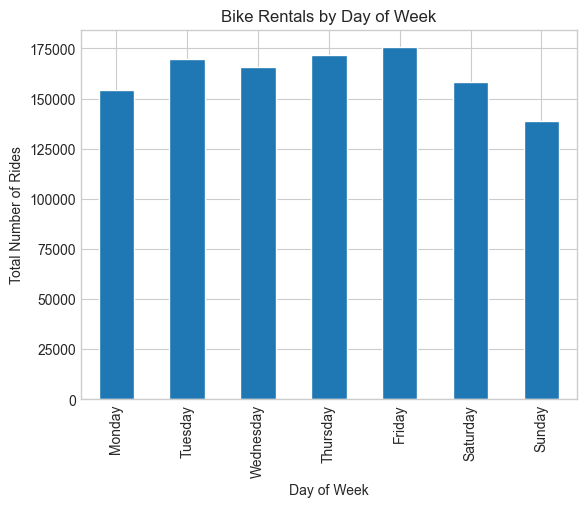

In [59]:
# Same thing but day of week
weekly_counts = combined_df.groupby('day_of_week')['ride_id'].count()

# Map numbers to days
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_counts.index = weekly_counts.index.map(lambda x: day_names[x])

# Plot results
weekly_counts.plot(kind='bar',
                   title='Bike Rentals by Day of Week',
                   xlabel='Day of Week',
                   ylabel='Total Number of Rides')

### Number of rides vs. Average Temperature

<Axes: title={'center': 'Daily Bike Rides vs Average Temperature'}, xlabel='Average Temperature (C)', ylabel='Total Daily Rides'>

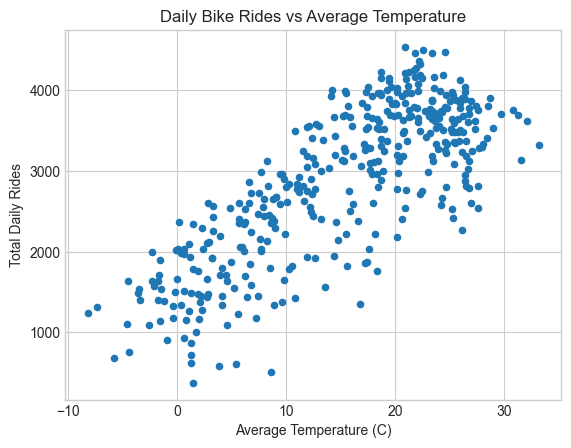

In [60]:
merged_df.plot(kind='scatter',
               x='tavg',
               y='ride_count',
               title='Daily Bike Rides vs Average Temperature',
               xlabel='Average Temperature (C)',
               ylabel='Total Daily Rides')


### Correlation Heatmap showing relationship between temperature, wind, and precipitation to ride frequency

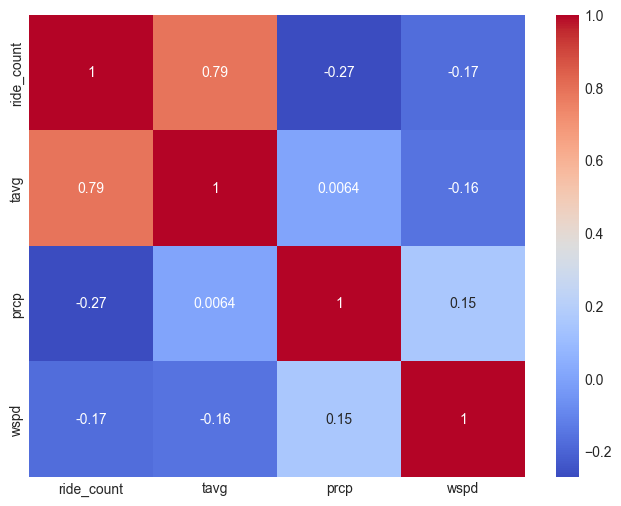

In [61]:
# Correlation Heatmap
numeric_df=merged_df[['ride_count', 'tavg', 'prcp', 'wspd']]

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

### Filtering out outliers, rides shorter than 2-minutes or longer than 180-minutes

In [62]:
# New DataFrame filtering out extreme ride length outliers
plot_df = combined_df[(combined_df['ride_duration_minutes'] > 2) & (combined_df['ride_duration_minutes'] < 180)]


### Violin Plot showing differences in ride lengths between members and casual riders

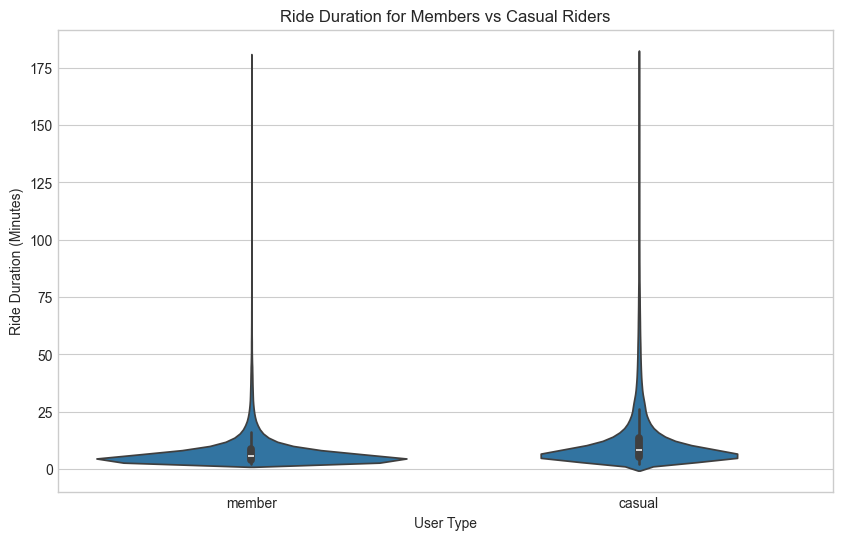

In [63]:
# Violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_df, x='member_casual', y='ride_duration_minutes')
plt.title('Ride Duration for Members vs Casual Riders')
plt.xlabel('User Type')
plt.ylabel('Ride Duration (Minutes)')
plt.show()

### Zoom in to show more clearly difference between members and casuals

In [64]:
plot_df = combined_df[(combined_df['ride_duration_minutes'] > 2) & (combined_df['ride_duration_minutes'] < 45)]


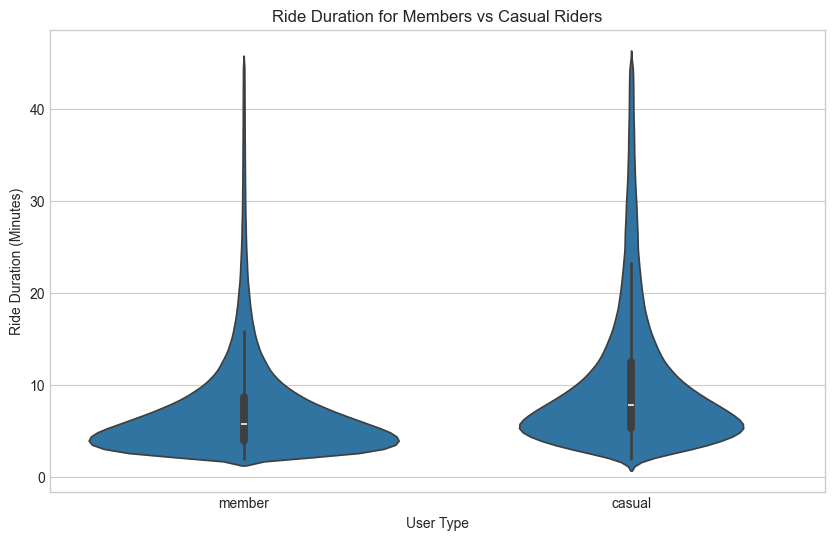

In [65]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_df, x='member_casual', y='ride_duration_minutes')
plt.title('Ride Duration for Members vs Casual Riders')
plt.xlabel('User Type')
plt.ylabel('Ride Duration (Minutes)')
plt.show()

### Determining the busiest start stations

<Axes: title={'center': 'Top 10 Busiest Start Stations'}, ylabel='start_station_name'>

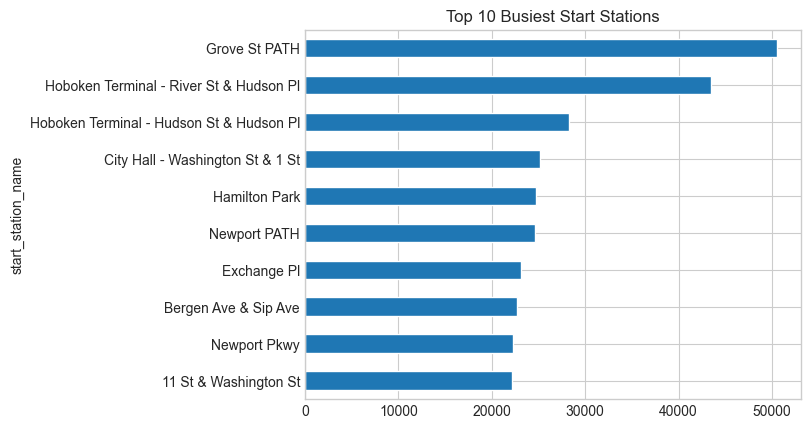

In [66]:
# Counts for top 10 stations
top_10_stations = combined_df['start_station_name'].value_counts().head(10)

# Bar Chart
top_10_stations.sort_values().plot(kind='barh', title='Top 10 Busiest Start Stations')

### Dual axis chart showing the relationship between temperature and ride frequency over an entire year.

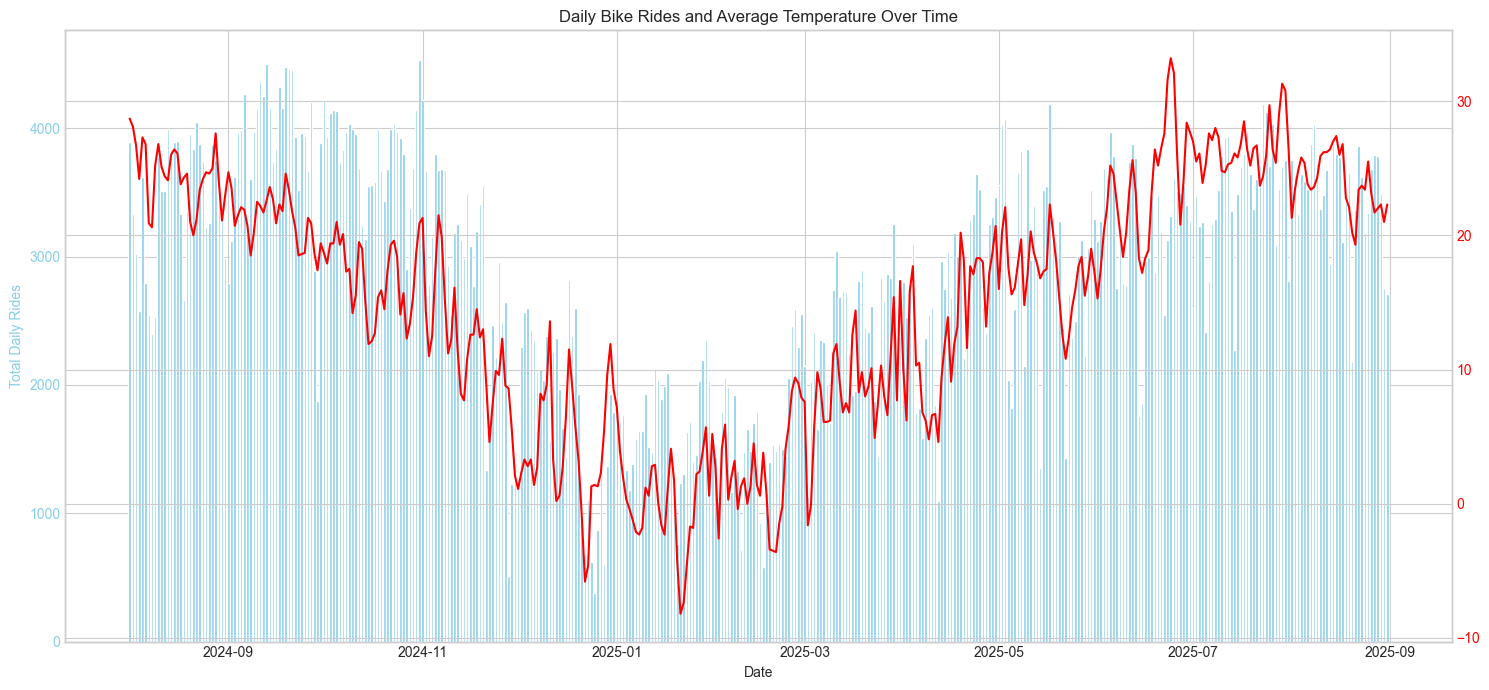

In [67]:
plot_data = merged_df.set_index('date')

fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.bar(plot_data.index, plot_data['ride_count'], color='skyblue', label='Ride Count')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Daily Rides', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

ax2 = ax1.twinx()

ax2.plot(plot_data.index, plot_data['tavg'], color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Daily Bike Rides and Average Temperature Over Time')
fig.tight_layout()
plt.show()

### Linear Regression. Predict riders based on weather conditions

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np 

model_df = merged_df[['tavg', 'prcp', 'wspd', 'ride_count']].copy()

for col in ['tavg', 'prcp', 'wspd']:
    model_df[col].fillna(model_df[col].mean(), inplace=True)

x = model_df[['tavg', 'prcp', 'wspd']]
y = model_df['ride_count']

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




### Split Data into Training and Testing

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Build and Train Model

In [70]:
model = LinearRegression()

model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [71]:
y_pred = model.predict(x_test)

r2 = metrics.r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)

print(f"R-squared: {r2:.2f}")
print(f"Mean Absolute Error: {mae:.2f} rides")

R-squared: 0.68
Mean Absolute Error: 401.46 rides


### Interpret Results

In [72]:
coeffs = pd.DataFrame(model.coef_, x.columns, columns=['Coefficient'])
print(coeffs)

      Coefficient
tavg    81.396452
prcp   -40.994351
wspd    -4.135611


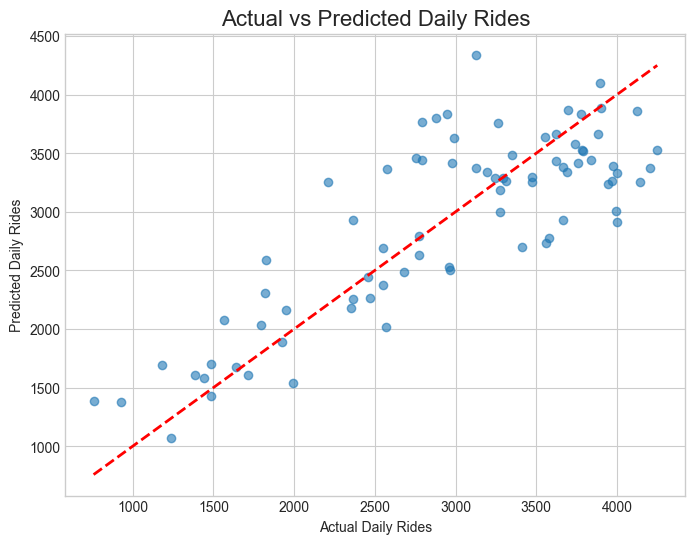

In [73]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='red')

plt.xlabel('Actual Daily Rides')
plt.ylabel('Predicted Daily Rides')
plt.title('Actual vs Predicted Daily Rides', fontsize=16)
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



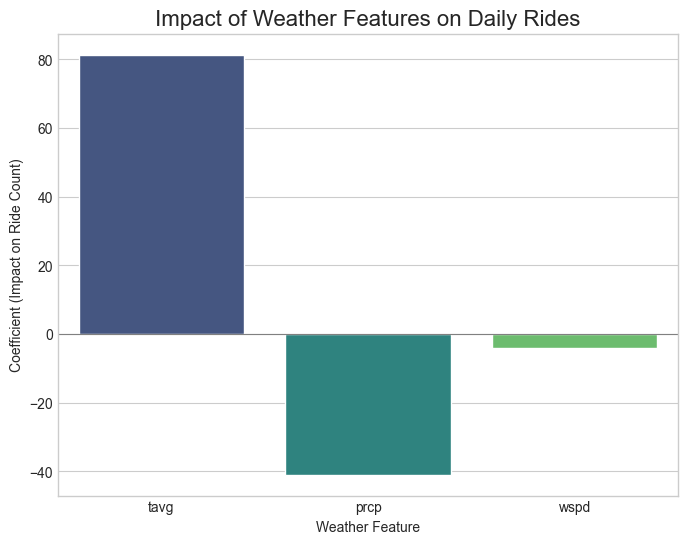

In [74]:
coeffs = pd.DataFrame(model.coef_, x.columns, columns=['Coefficient'])
coeffs = coeffs.reset_index().rename(columns={'index': 'Feature'})

plt.figure(figsize=(8, 6))
sns.barplot(data=coeffs, x='Feature', y='Coefficient', palette='viridis')

plt.axhline(0, color='grey', linewidth=0.8)

plt.ylabel('Coefficient (Impact on Ride Count)')
plt.xlabel('Weather Feature')
plt.title('Impact of Weather Features on Daily Rides', fontsize=16)
plt.show()

### Poisson

In [75]:
# Prepare the data
model_df = merged_df[['tavg', 'prcp', 'wspd', 'ride_count']].copy()

# Ensure columns are numeric for statsmodels
model_cols = ['tavg', 'prcp', 'wspd', 'ride_count']

for col in model_cols:
    model_df[col] = pd.to_numeric(model_df[col], errors='coerce')

for col in ['tavg', 'prcp', 'wspd']:
    model_df[col].fillna(model_df[col].mean(), inplace=True)

model_df.dropna(subset=['ride_count'], inplace=True)

# Define predictor and response variable
X = model_df[['tavg', 'prcp', 'wspd']]
y = model_df['ride_count']

# Add constant to predictors
X = sm.add_constant(X)

X = X.astype(float)

# Build and fit model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Print model summary
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             ride_count   No. Observations:                  396
Model:                            GLM   Df Residuals:                      392
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26227.
Date:                Tue, 23 Sep 2025   Deviance:                       48604.
Time:                        12:13:00   Pearson chi2:                 4.58e+04
No. Iterations:                     4   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5261      0.004   2068.769      0.0

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



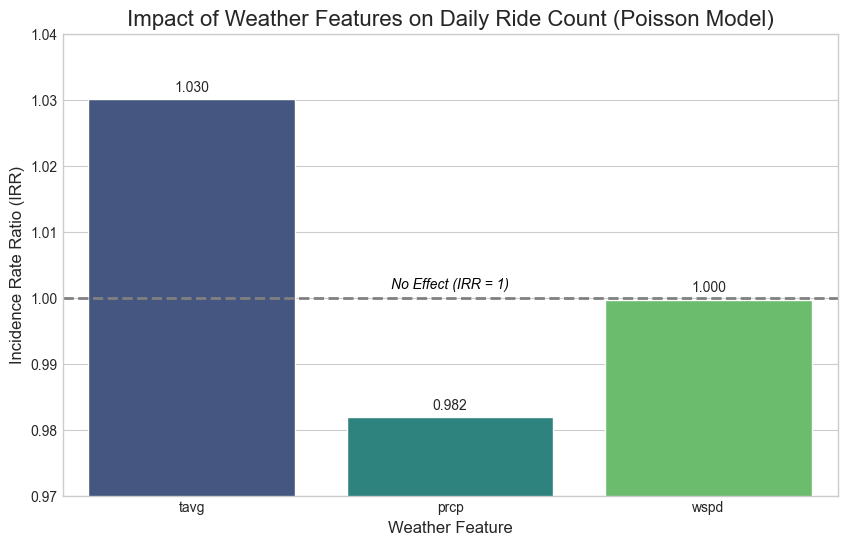

In [76]:
# Add results from above table

results_data = {
    'feature': ['tavg', 'prcp', 'wspd'],
    'coefficient': [0.0296, -0.0183, -0.0003]
}
results_df = pd.DataFrame(results_data).set_index('feature')

# Calculate the Incidence Rate Ratios
results_df['IRR'] = np.exp(results_df['coefficient'])

# Create the bar plot
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=results_df.index, y=results_df['IRR'], palette='viridis')

# Add a horizontal line at 1.0 for reference
plt.axhline(y=1.0, color='grey', linestyle='--', linewidth=2)

# Add data labels on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.3f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

# Add titles and labels
plt.title('Impact of Weather Features on Daily Ride Count (Poisson Model)', fontsize=16)
plt.xlabel('Weather Feature', fontsize=12)
plt.ylabel('Incidence Rate Ratio (IRR)', fontsize=12)
plt.ylim(0.97, 1.04) # Zoom in on the y-axis to see the effects more clearly
plt.text(x=1, y=1.001, s='No Effect (IRR = 1)', color='black', va='bottom', ha='center', fontsize=10, style='italic')

# Display the plot
plt.show()

### Model Summary

The Poisson regression model quantifies the impact of key weather variables on daily bike ridership. The results indicate that temperature and precipitation are significant predictors, while wind speed is not.

- Temperature (tavg): There is a strong, positive correlation between temperature and ridership. For every 1°C increase in average temperature, the number of daily rides is predicted to increase by 3.0%.

- Precipitation (prcp): Precipitation acts as a significant deterrent. For every 1 mm of rain, the daily ride count is predicted to decrease by 1.8%.

- Wind Speed (wspd): The model found no statistically significant evidence that wind speed affects the number of daily rides.

# Conclusion

This analysis of NYC bike rental data indicates a strong correlation between ridership and weather patterns, with daily ride counts tending to increase with warmer temperatures. Usage patterns also show clear variations across the day and week, with distinct peaks that align with typical weekday commuting hours. Furthermore, the data highlights a significant difference in usage behavior between casual riders and annual members, most notably in their average trip durations. These observations suggest that weather, commuting schedules, and user type are key factors associated with how the bike share service is used.

## Key Findings

- Strong Correlation with Weather: The analysis reveals a strong, positive correlation (r=0.79) between the average daily temperature and the number of rides. Conversely, there is a negative correlation with precipitation. This suggests that pleasant weather is a significant factor associated with higher ridership.

- Distinct Weekday Commuting Patterns: Hourly usage data shows two primary peaks during weekdays, at 8 AM and 5-6 PM, which strongly suggests the service is a popular option for commuting to and from work.

- Different Usage by Rider Type: Casual riders, on average, take significantly longer trips than members. This may indicate different primary use cases between the groups, with members potentially using the service for efficient, shorter trips while casual riders engage in more leisurely rides.

- Geographic Concentration of Demand: A small number of stations, particularly those near major transit hubs like Grove St PATH and Hoboken Terminal, account for a disproportionately high volume of ride starts. This indicates these locations are critical points in the network.
- Statistical testing revealed that the presence of missing data is not random but has a significant association with the user type.

## Model-Driven Conclusions

- The linear regression and Poisson general regression models validates that weather is a primary predictive driver for ridership.

- The analysis successfully quantifies the impact of key weather variables, demonstrating a strong positive correlation with temperature (~81 additional rides per +1°C) and a significant negative correlation with precipitation (~41 fewer rides per mm of rain).

- This predictive model serves as a practical tool for demand forecasting, enabling more proactive operational strategies, such as optimizing bike redistribution based on upcoming weather forecasts.

## Actionable Insights

Based on the correlations observed in the data, the following strategic opportunities could be considered:

- Targeted Marketing Opportunities: Given the different ride duration patterns, marketing efforts could be tailored. For example, campaigns targeting casual users might promote "weekend sightseeing routes," while member-focused content could emphasize the service's reliability and efficiency for daily commutes.

- Optimized Bike Distribution: The station popularity data can inform logistical strategies. Ensuring higher bike availability at the busiest stations just before the morning and evening commute peaks could enhance service reliability and potentially increase customer satisfaction.

- Demand Management Strategies: To help mitigate the observed drop in ridership on days with poor weather, the service could explore piloting a dynamic pricing model, such as offering "rainy day discounts" to incentivize use during off-peak conditions.